In [1]:
from interarray.importer import load_repository
from interarray.svg import svgplot
from interarray.mesh import make_planar_embedding
from interarray.interarraylib import G_from_S
from interarray.heuristics import EW_presolver
from interarray.MILP import pyomo as omo
from interarray.pathfinding import PathFinder

In [2]:
from pyomo import environ as pyo

## Load interarray's locations

In [3]:
locations = load_repository()

## Optimize Gwynt y Mor

In [4]:
L = locations.gwynt
capacity = 6

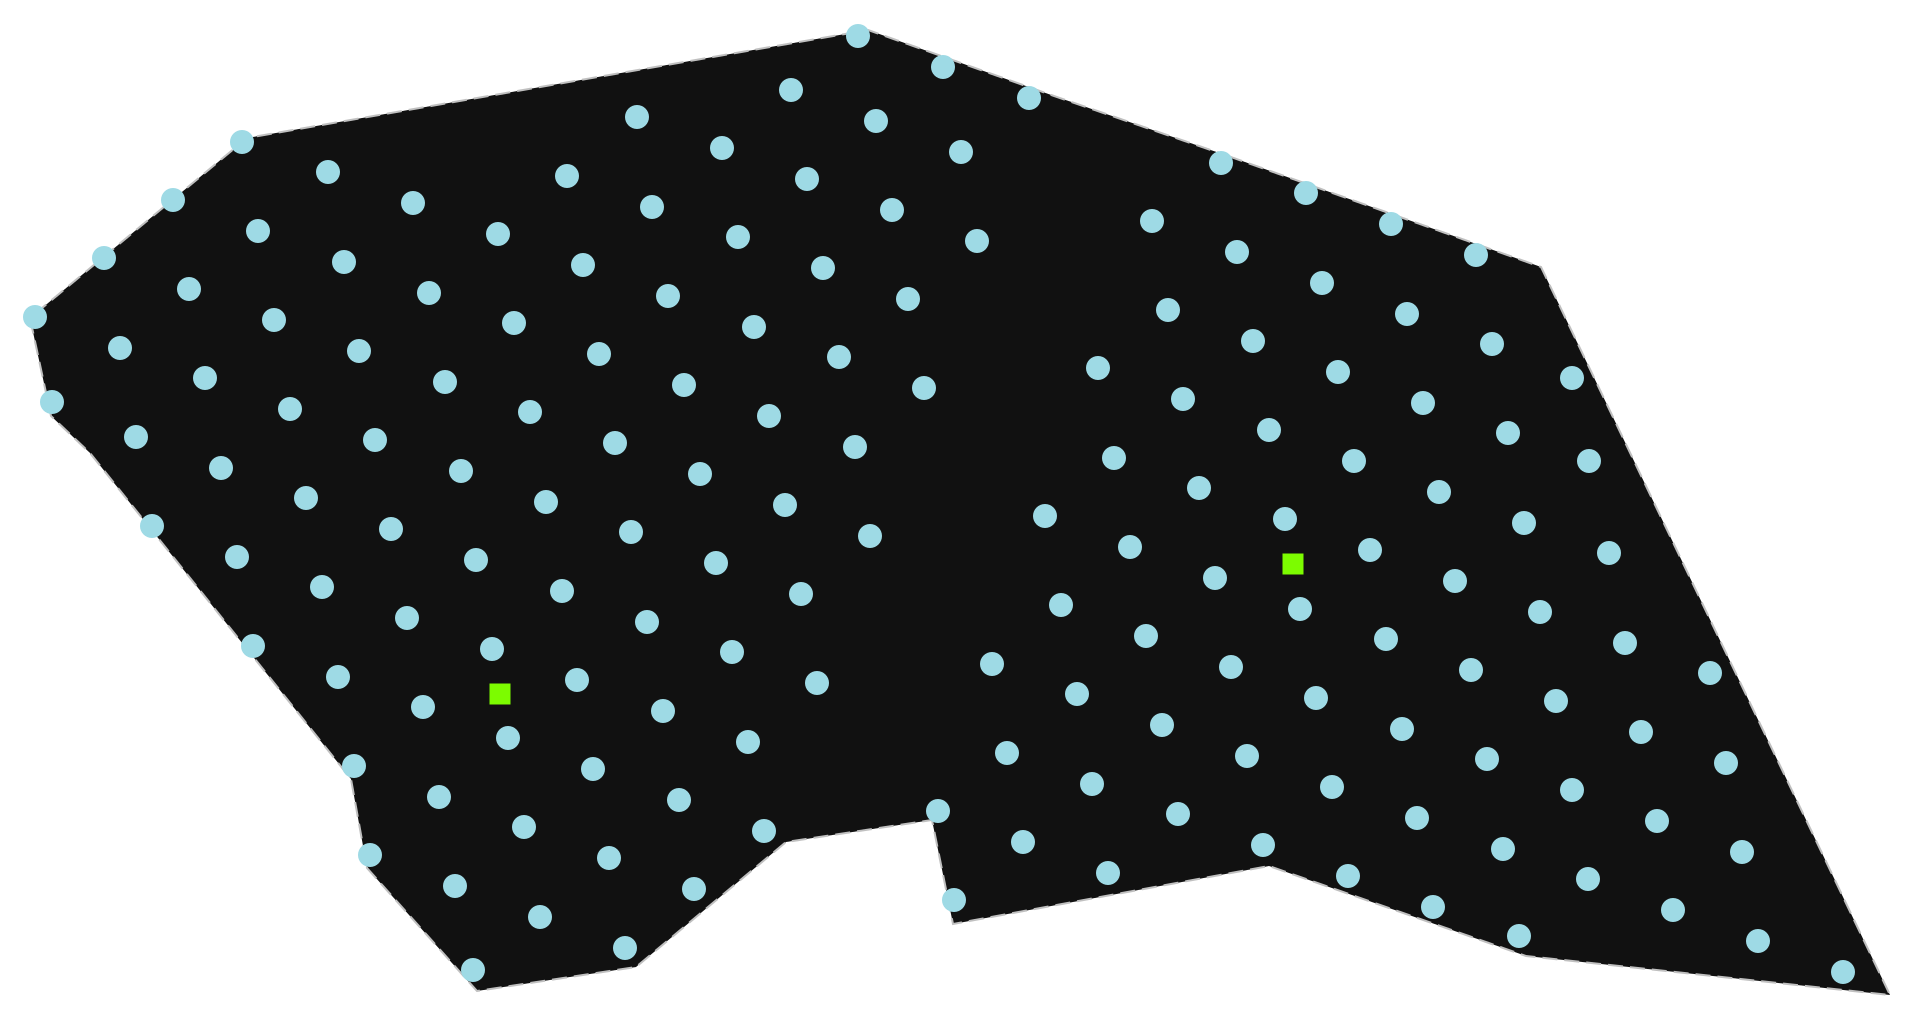

In [5]:
svgplot(L)

In [6]:
P, A = make_planar_embedding(L)

Initial heuristic solution to warm-start the solver:

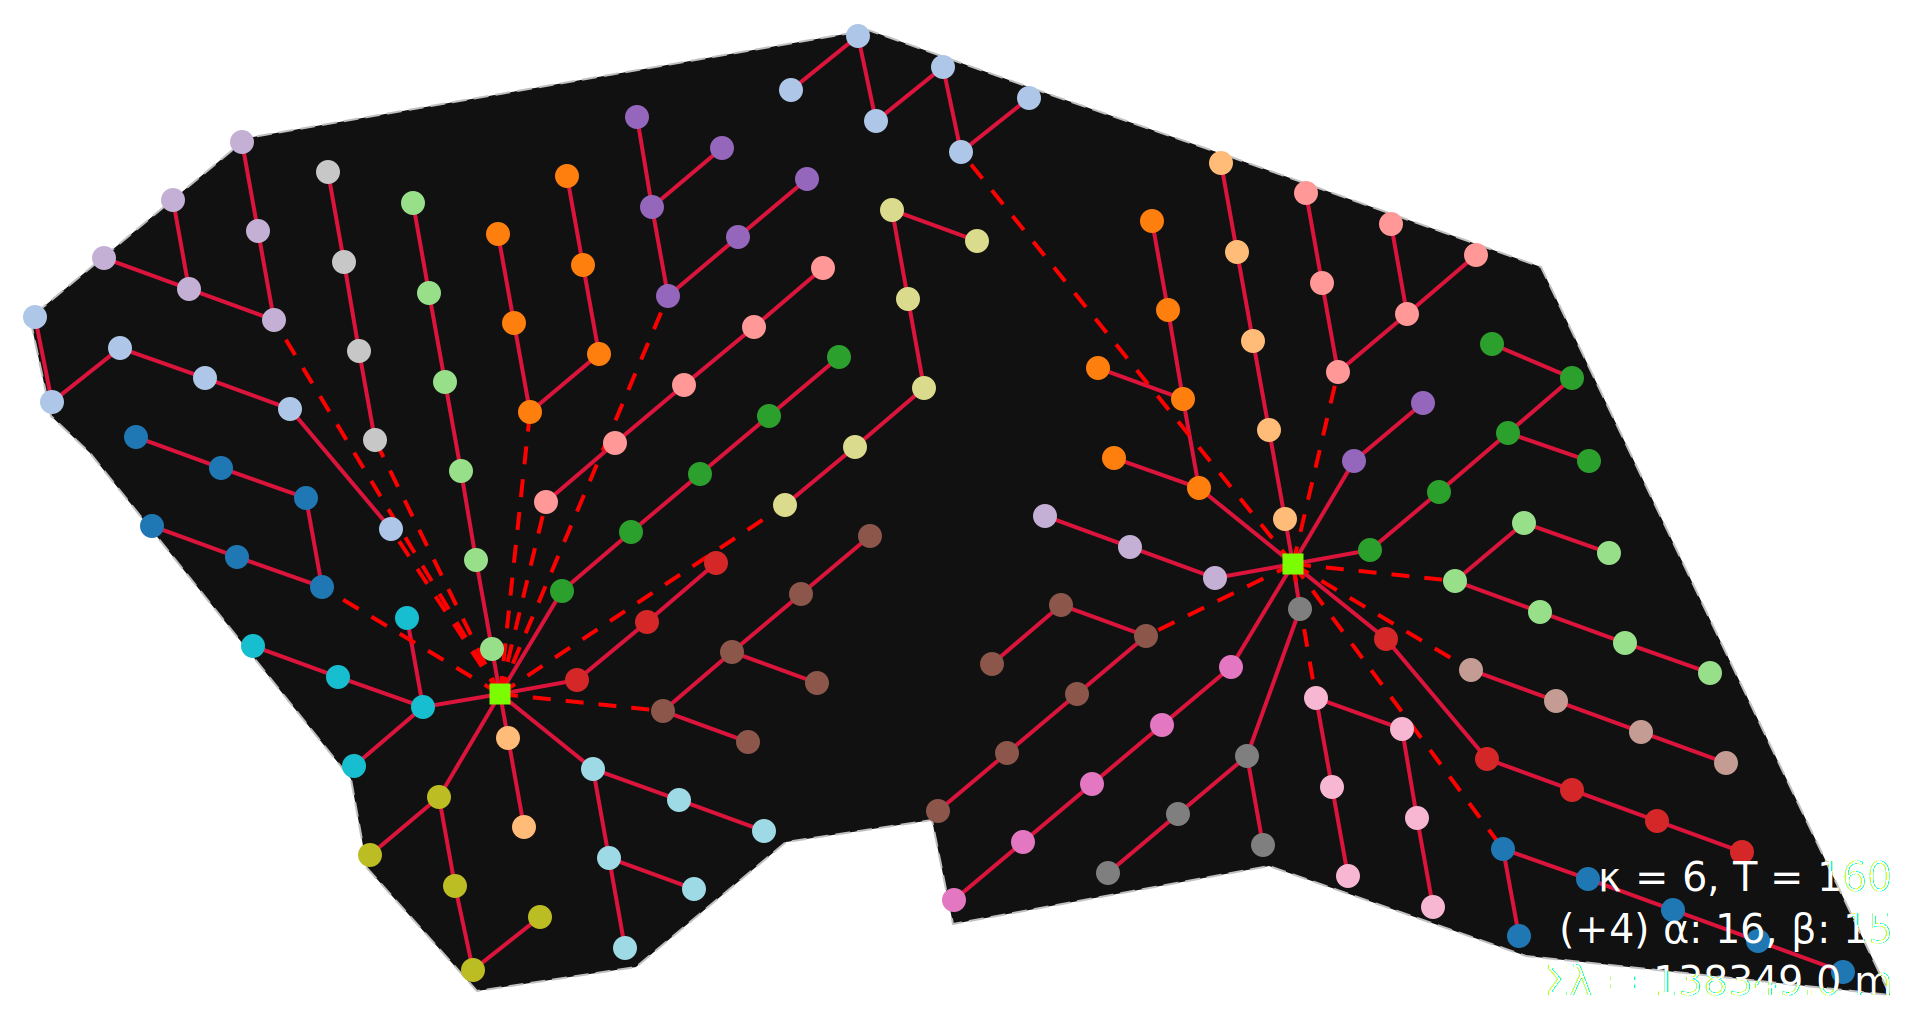

In [7]:
Sʹ = EW_presolver(A, capacity=capacity)
Gʹ = G_from_S(Sʹ, A)
svgplot(Gʹ)

In [8]:
model = omo.make_min_length_model(
    A, capacity,
    gateXings_constraint=False,
    branching=True,
    gates_limit=False
)
omo.warmup_model(model, Sʹ);

The pyomo GurobiDirect class can work as context manager by passing the `manage_env=True` parameter to SolverFactory. Advantages of operating this way:
- the Gurobi license is released after the context's scope ends
- one can pass `options` that can only be set at the Gurobi environment creation (such as `threadlimit`)

In [9]:
with pyo.SolverFactory('gurobi', solver_io='python', manage_env=True,
                       options={'threadlimit': 16}) as gurober:
    print(gurober.available(), type(gurober))
    gurober.options.mipgap = 0.005  # relative lower-bound to objective-value gap
    gurober.options.timelimit = 90  # seconds
    gurober.options.mipfocus = 1  # focus on producing solutions
    print(f'Solving "{model.handle}": {{R={len(model.R)}, T={len(model.T)}, κ={model.k.value}}}\n')
    result = gurober.solve(model, warmstart=model.warmed_by, tee=True)

True <class 'pyomo.solvers.plugins.solvers.gurobi_direct.GurobiDirect'>
Solving "gwynt": {R=2, T=160, κ=6}

Set parameter OutputFlag to value 1
Set parameter MIPGap to value 0.005
Set parameter TimeLimit to value 90
Set parameter MIPFocus to value 1
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
TimeLimit  90
MIPGap  0.005
MIPFocus  1

Academic license 937681 - for non-commercial use only - registered to ma___@dtu.dk
Optimize a model with 6093 rows, 3972 columns and 22844 nonzeros
Model fingerprint: 0x7e2889a1
Variable types: 0 continuous, 3972 integer (1986 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+00]
  Objective range  [4e+02, 1e+04]
  Bounds range     [1e+00, 6e+00]
  RHS range        [1e+00, 2e+02]

Loaded user MIP start with ob

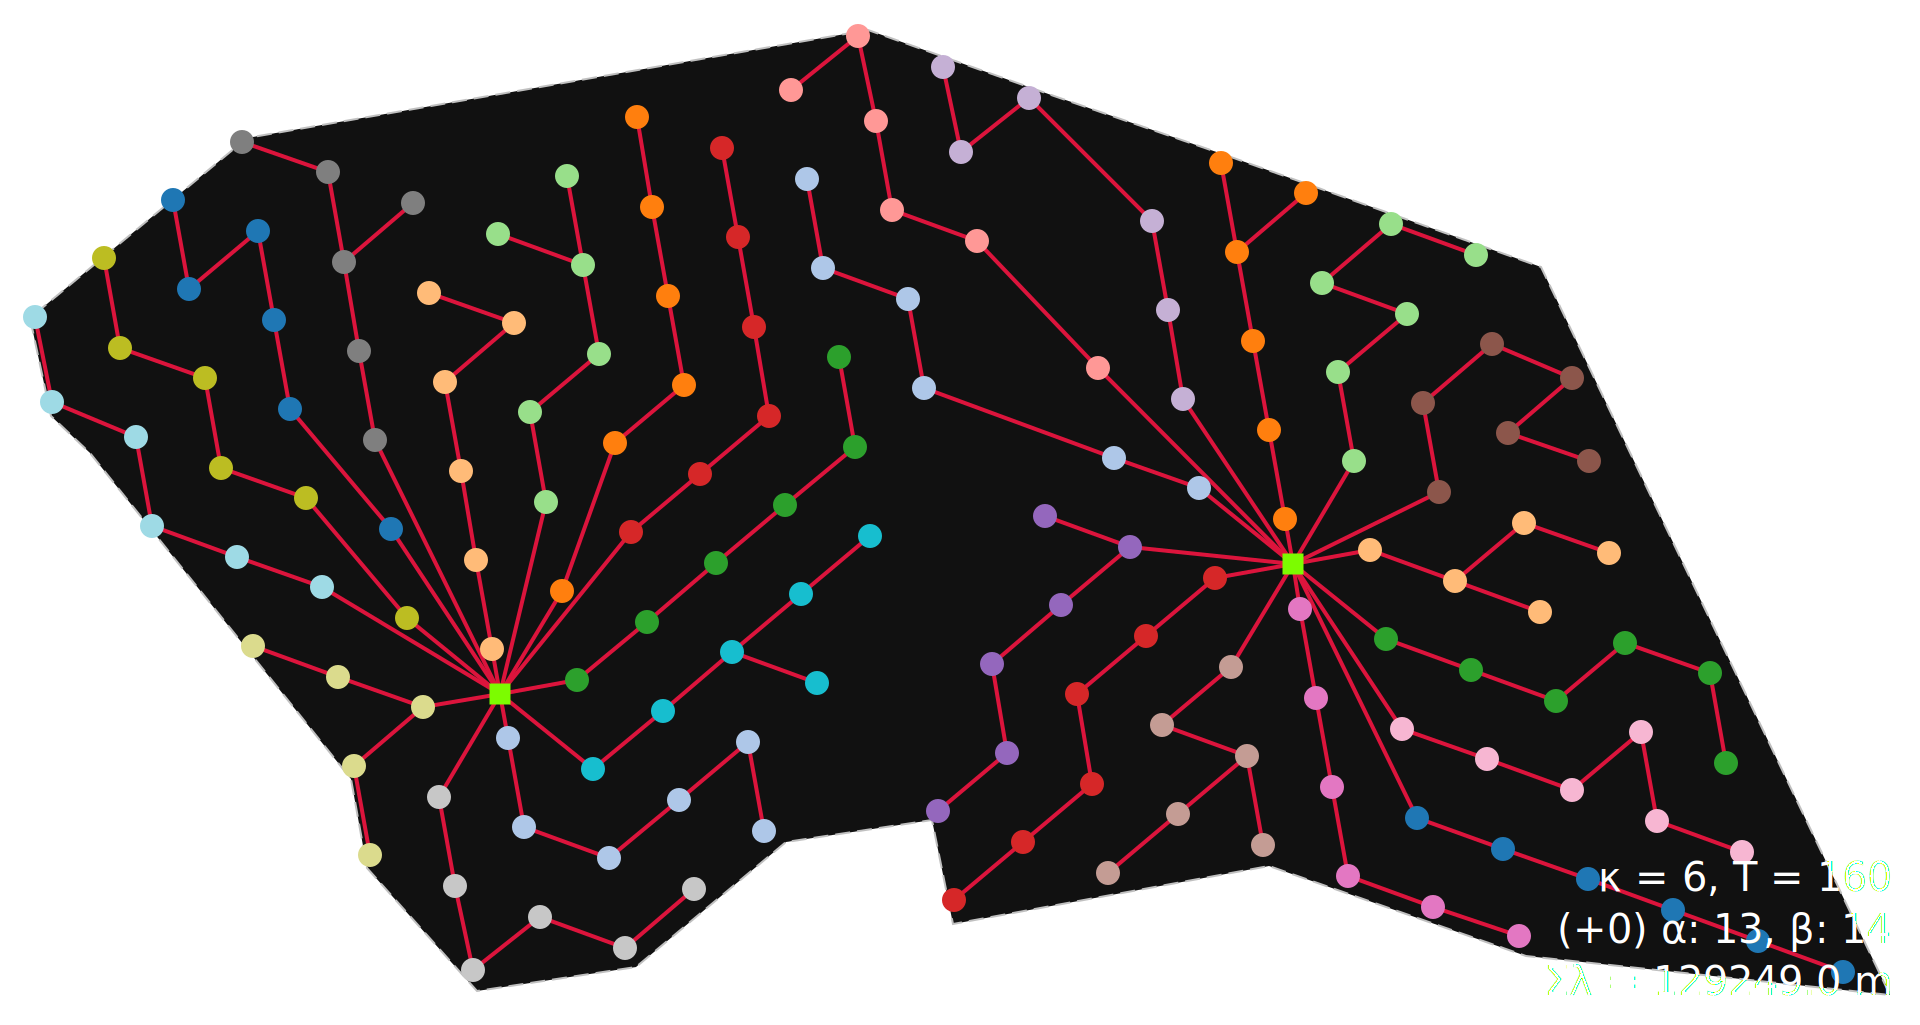

In [10]:
S = omo.S_from_solution(model, gurober, result)
G = G_from_S(S, A)
H = PathFinder(G, planar=P, A=A).create_detours()
svgplot(H)